# Project Gutenberg Analysis: Data Collection

### Notebook 01: Python Data Collection

Welcome to the data collection phase of my Project Gutenberg historical analysis. In this notebook, I'll gather metadata from Project Gutenberg's catalog to explore the evolution of publishing through their extensive digital library.


## What this notebook covers
1. Setting up the environment and dependencies
2. Connecting to the Gutenberg API
3. Collecting and structuring metadata
4. Initial data validation
5. Saving the dataset for further analysis

I will begin by importing the required libraries and setting up the environment.

In [57]:
import pandas as pd
import requests
import json
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up the plotting style
sns.set_theme()

# Create data directories, if they don't exist
Path('../data/raw').mkdir(parents=True, exist_ok=True)
Path('../data/processed').mkdir(parents=True, exist_ok=True)

## API Connection and Data Collection

I'll use the Gutendex API, a modern JSON web API for Project Gutenberg, so I'll create a function to handle the API requests and collect the metadata.
![Gutendex]()

In [59]:
class GutenbergCollector:
    def __init__(self):
        self.base_url = 'https://gutendex.com/books'
        self.books = []
    
    def fetch_catalog(self, max_pages=5000):
        """Fetch book metadata from the Gutenberg API"""
        next_page = self.base_url
        
        with tqdm(total=max_pages, desc='Fetching pages') as pbar:
            while next_page and len(self.books) < max_pages * 32:  # 32 books per page
                try:
                    response = requests.get(next_page)
                    response.raise_for_status()
                    data = response.json()
                    
                    # Process each book to add derived fields
                    for book in data['results']:
                        # Get text length from formats if available
                        formats = book.get('formats', {})
                        if 'text/plain' in formats:
                            # Check if the format is a dictionary or string
                            format_info = formats['text/plain']
                            if isinstance(format_info, dict):
                                book['text_length'] = format_info.get('size', 0)
                            else:
                                book['text_length'] = 0
                        else:
                            book['text_length'] = 0
                            
                        # Get available formats list
                        book['available_formats'] = list(formats.keys())
                    
                    self.books.extend(data['results'])
                    next_page = data.get('next')
                    pbar.update(1)
                    
                except requests.exceptions.RequestException as e:
                    print(f"Error fetching data: {e}")
                    break
        
        print(f"Successfully collected metadata for {len(self.books)} books")
        return self.books
    
    def save_raw_data(self):
        """Save the raw JSON data"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'../data/raw/gutenberg_catalog_{timestamp}.json'
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.books, f, ensure_ascii=False, indent=2)
        
        print(f"Raw data saved to {filename}")
        return filename

# Initialize the collector and fetch the data
collector = GutenbergCollector()
books = collector.fetch_catalog(max_pages=5000) 
raw_file = collector.save_raw_data()

Fetching pages:  42%|████▏     | 2111/5000 [4:04:56<5:35:12,  6.96s/it]


KeyboardInterrupt: 

## Initial Data Processing

Now that I have the raw data, I will transform it into a structured DataFrame and perform some initial cleaning.

In [60]:
def process_raw_data(books):
    """Transform raw book data into a structured DataFrame"""
    processed_books = []
    
    for book in books:
        processed_book = {
            'id': book['id'],
            'title': book['title'],
            'authors': '; '.join([author['name'] for author in book['authors']]),
            'languages': '; '.join(book['languages']),
            'download_count': book['download_count'],
            'subjects': '; '.join(book['subjects'] if book['subjects'] else []),
            'bookshelves': '; '.join(book['bookshelves'] if book['bookshelves'] else []),
            'copyright': book['copyright'],
            'text_length': book.get('text_length', 0),
           'available_formats': '; '.join(book.get('available_formats', []))
        }
        processed_books.append(processed_book)
    
    return pd.DataFrame(processed_books)

# Process collected data
df = process_raw_data(books)

# Display basic information about dataset
print("Dataset Overview:")
print("-" * 50)
print(df.info())
print("\nSample of processed data:")
display(df.head())

Dataset Overview:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74896 entries, 0 to 74895
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 74896 non-null  int64 
 1   title              74896 non-null  object
 2   authors            74896 non-null  object
 3   languages          74896 non-null  object
 4   download_count     74896 non-null  int64 
 5   subjects           74896 non-null  object
 6   bookshelves        74896 non-null  object
 7   copyright          74896 non-null  bool  
 8   text_length        74896 non-null  int64 
 9   available_formats  74896 non-null  object
dtypes: bool(1), int64(3), object(6)
memory usage: 5.2+ MB
None

Sample of processed data:


,id,title,authors,languages,download_count,subjects,bookshelves,copyright,text_length,available_formats
0,25558,呻吟語,"Lü, Kun",zh,259762,Conduct of life,Browsing: Philosophy & Ethics; Browsing: Psych...,False,0,
1,84,"Frankenstein; Or, The Modern Prometheus","Shelley, Mary Wollstonecraft",en,107767,Frankenstein's monster (Fictitious character) ...,Browsing: Culture/Civilization/Society; Browsi...,False,0,
2,46,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",en,93151,Christmas stories; Ghost stories; London (Engl...,Browsing: Children & Young Adult Reading; Brow...,False,0,
3,2701,"Moby Dick; Or, The Whale","Melville, Herman",en,72020,"Adventure stories; Ahab, Captain (Fictitious c...",Best Books Ever Listings; Browsing: Fiction; B...,False,0,
4,1513,Romeo and Juliet,"Shakespeare, William",en,67820,Conflict of generations -- Drama; Juliet (Fict...,Browsing: Fiction; Browsing: Literature; Brows...,False,0,


## Data Quality Check

Here I'll perform some initial validation to ensure the data is complete and accurate, such as checking for missing values, that key fiels only contain unique values, and printing basic download statistics.

In [61]:
def check_data_quality(df):
    """Perform basic data quality checks"""
    print("Data Quality Report")
    print("-" * 50)
    
    # Check for missing values
    missing_data = df.isnull().sum()
    print("\nMissing Values:")
    print(missing_data[missing_data > 0])
    
    # Check unique values in key fields
    print("\nUnique Languages:", df['languages'].nunique())
    print("Unique Authors:", df['authors'].nunique())
    
    # Basic statistics for download counts
    print("\nDownload Count Statistics:")
    print(df['download_count'].describe())

check_data_quality(df)

Data Quality Report
--------------------------------------------------

Missing Values:
Series([], dtype: int64)

Unique Languages: 119
Unique Authors: 24837

Download Count Statistics:
count     74896.000000
mean        180.829644
std        1439.012229
min           0.000000
25%          61.000000
50%          82.000000
75%         129.000000
max      259762.000000
Name: download_count, dtype: float64


Based on this Data Quality Report, I have some key observations:

### Data Completeness:
The dataset is remarkably clean with no missing values (empty Series for Missing Values), which suggests high-quality data collection from the Gutenberg API. The dataset contains 74,896 books in total.

### Language Distribution:
There are 119 unique languages indicates a diverse set of languages, and this is a reasonable number for meaningful language analysis, neither too small nor too overwhelming. It is worth noting that Project Gutenberg is based in the US and is primarily English-focused, so this likely represents good language coverage.

### Author Diversity:
There are 24,837 unique authors across 74,896 books, which averages to roughly 3 books per author, suggesting a good mix of authors rather than dominance by a few prolific writers and this diversity is beneficial for analyzing historical publishing patterns.

### Download Statistics:
There is a wide range in popularity: from 0 to 259,762 downloads, and a highly skewed distribution: the mean (181) is much higher than the median (82), indicating some extremely popular outliers. 75% of books have fewer than 129 downloads, but the mean is pulled up by popular works. The relatively small differences between quartiles (Q1: 61, Q2: 82, Q3: 129) compared to the maximum suggests that most books cluster in a relatively narrow range of low downloads.
The standard deviation (1,439) being larger than the mean suggests high variability in book popularity.

The Data Quality Report suggests a robust dataset for historical analysis, with good completeness and reasonable distributions across key metrics. Later, the skewed download counts could provide interesting insights into what makes certain books particularly popular in digital format.
## Quick Visualization

I'll make a simple visualization to get a sense of the data distribution.

In [62]:
def create_visualizations(df):
    # Set up the figure
    sns.set_theme(style="white")
    fig = plt.figure(figsize=(15, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1], wspace=0.3)
    
    # Download count visualization
    ax1 = fig.add_subplot(gs[0])
    
    # Create bins on a log scale for better distribution visibility
    download_data = df['download_count']
    bins = np.logspace(np.log10(max(1, download_data.min())), 
                      np.log10(download_data.max()), 
                      50)
    
    # Plot histogram with log scale
    ax1.hist(download_data, bins=bins, alpha=0.6, color='#4e79a7')
    ax1.set_xscale('log')
    
    # Add vertical lines for mean and median
    median = df['download_count'].median()
    mean = df['download_count'].mean()
    ymin, ymax = ax1.get_ylim()
    
    ax1.vlines(median, ymin, ymax*0.9, colors='#e15759', linestyles='--', 
               label=f'Median: {median:.0f}')
    ax1.vlines(mean, ymin, ymax*0.9, colors='#59a14f', linestyles='--', 
               label=f'Mean: {mean:.0f}')
    
    # Customize axes
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('Download Count Distribution (Log Scale)', pad=20, fontsize=11)
    ax1.set_xlabel('Number of Downloads', fontsize=10)
    ax1.set_ylabel('Number of Books', fontsize=10)
    ax1.legend(frameon=False)
    
    # Language distribution
    ax2 = fig.add_subplot(gs[1])
    
    # Calculate language percentages
    languages = df['languages'].str.split('; ').explode()
    lang_counts = languages.value_counts()
    lang_percentages = (lang_counts / lang_counts.sum() * 100).head(8)
    
    # Create horizontal bars
    bars = ax2.barh(
        range(len(lang_percentages)),
        lang_percentages,
        color='#4e79a7',
        alpha=0.6,
        height=0.6
    )
    
    # Remove spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add percentage labels
    for i, (bar, percentage) in enumerate(zip(bars, lang_percentages)):
        ax2.text(
            percentage + 0.3,
            i,
            f'{percentage:.1f}%',
            va='center',
            fontsize=9,
            color='#404040'
        )
    
    # Customize axes
    ax2.set_title('Language Distribution', pad=20, fontsize=11)
    ax2.set_xlabel('Percentage of Collection', fontsize=10)
    ax2.set_yticks(range(len(lang_percentages)))
    ax2.set_yticklabels([lang.upper() for lang in lang_percentages.index], fontsize=9)
    ax2.grid(False)
    
    plt.savefig('../visualisations/dataimport_distribution.png',dpi=300)
    plt.tight_layout()
    return fig

/var/folders/11/kxlf585x3sx77xpyt3j79cbh0000gn/T/ipykernel_73093/76191843.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


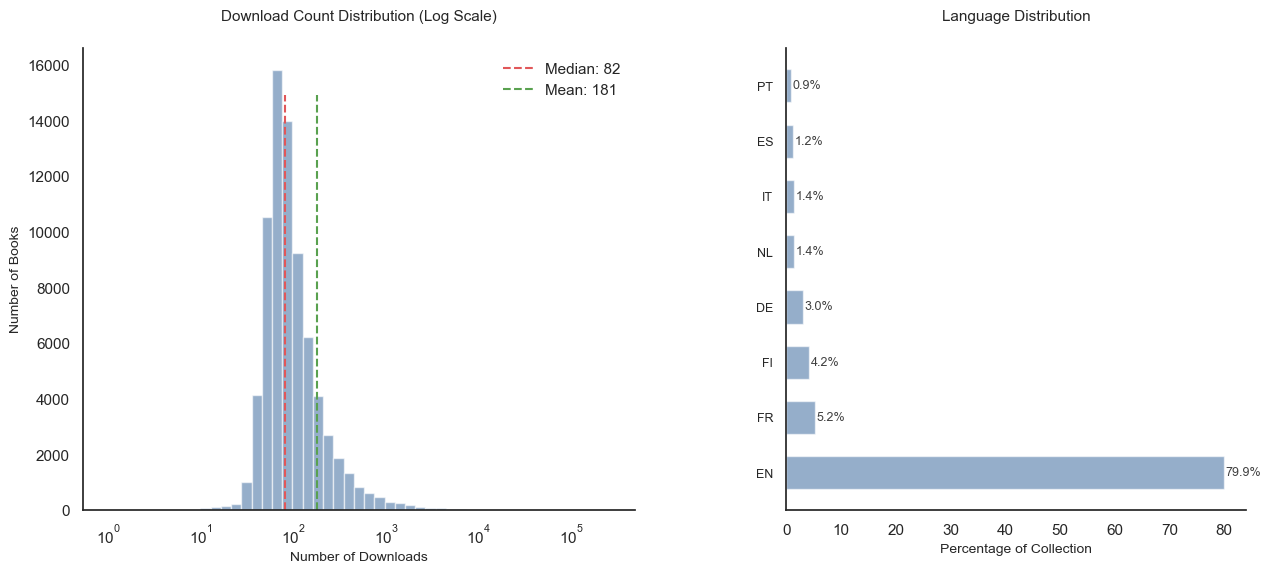

In [63]:
# Show figures
fig = create_visualizations(df)
plt.show()

This visualization shows aspects of the Project Gutenberg dataset:

1. Download Count Distribution (Left):
- Shows a clear right-skewed distribution on a logarithmic scale
- The median download count is 1,414 (red dashed line)
- The mean download count is 3,259 (green dashed line)
- The significant difference between mean and median confirms the strong right skew
- Most books cluster around 103 (1,000) downloads, with a long tail extending to 105

2. Language Distribution (Right):
- English (EN) dominates at 80.1% of the collection
- French (FR) is a second at 5.2%
- Finnish (FI) is at 4.2%
- German (DE) follows at 3.0%
- Dutch (NL) is at 1.4%
- Italian is at 1.5%
- Spanish (ES) at 1.6%
- Portuguese (PT) at 0.9%

This visualization shows both the concentration of downloads around a central tendency and the strong English-language bias in the Project Gutenberg collection.

In [43]:
def analyze_language_distribution(df):
    """
    Analyze and display detailed language distribution statistics
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing a 'languages' column
    
    Returns:
    pandas.DataFrame: DataFrame with language statistics
    """
    # Split the language strings and create individual entries
    languages = df['languages'].str.split('; ').explode()
    
    # Calculate basic counts and percentages
    lang_stats = pd.DataFrame({
        'count': languages.value_counts(),
        'percentage': (languages.value_counts() / len(df) * 100).round(1)
    }).reset_index()
    
    # Rename columns
    lang_stats.columns = ['Language', 'Number of Books', 'Percentage']
    
    # Add cumulative percentage
    lang_stats['Cumulative %'] = lang_stats['Percentage'].cumsum().round(1)
    
    # Calculate average downloads per language
    lang_downloads = df.copy()
    lang_downloads['languages'] = lang_downloads['languages'].str.split('; ')
    lang_downloads = lang_downloads.explode('languages')
    avg_downloads = lang_downloads.groupby('languages')['download_count'].agg(['mean', 'median']).round(1)
    
    # Merge with main stats
    lang_stats = lang_stats.merge(
        avg_downloads, 
        left_on='Language', 
        right_index=True, 
        how='left'
    )
    
    # Rename columns
    lang_stats = lang_stats.rename(columns={
        'mean': 'Avg Downloads',
        'median': 'Median Downloads'
    })
    
    # Print formatted statistics
    print("\nLanguage Distribution Analysis")
    print("-" * 80)
    print(f"Total number of unique languages: {len(lang_stats)}")
    print(f"Languages making up 90% of collection: {len(lang_stats[lang_stats['Cumulative %'] <= 90])}")
    print("\nDetailed Statistics:")
    print(lang_stats.to_string(index=False))
    
    # Additional insights
    print("\nKey Insights:")
    print(f"- {lang_stats['Language'].iloc[0]} dominates with {lang_stats['Percentage'].iloc[0]}% of the collection")
    print(f"- Top 3 languages account for {lang_stats['Percentage'].iloc[:3].sum():.1f}% of all books")
    print(f"- Most downloaded language (avg): {lang_stats.nlargest(1, 'Avg Downloads')['Language'].iloc[0]}")
    print(f"- Number of languages with <1% representation: {len(lang_stats[lang_stats['Percentage'] < 1])}")
    
    return lang_stats


lang_stats = analyze_language_distribution(df)


Language Distribution Analysis
--------------------------------------------------------------------------------
Total number of unique languages: 70
Languages making up 90% of collection: 3

Detailed Statistics:
Language  Number of Books  Percentage  Cumulative %  Avg Downloads  Median Downloads
      en            60026        80.1          80.1          192.6              86.0
      fr             3911         5.2          85.3          122.1              73.0
      fi             3162         4.2          89.5           58.9              51.0
      de             2246         3.0          92.5          128.3              74.0
      nl             1030         1.4          93.9           83.7              67.0
      it             1028         1.4          95.3           92.2              71.0
      es              870         1.2          96.5          200.8              97.0
      pt              644         0.9          97.4          134.3              72.0
      hu              

Here, there is a difference between the unique languages in my initial statistic report (119) and the language analysis above (70). I will verify why this is happening by using two methods:
1. A raw count of unique values that include combinations
2. Looking at the data, some books are available in multiple languages and that is displayed in the data by a semicolon. I will split at the semicolon and then do the count.

In [ ]:
def verify_language_counts(df):
    """Verify language counts using different methods"""
    
    # Method 1: Raw count of unique values (including combinations)
    raw_count = df['languages'].nunique()
    
    # Method 2: Count of individual languages after splitting
    individual_langs = df['languages'].str.split('; ').explode().unique()
    
    # Print both counts and show some examples
    print("Language Count Analysis")
    print("-" * 50)
    print(f"Raw unique entries (including combinations): {raw_count}")
    print(f"Unique individual languages: {len(individual_langs)}")
    
    # Show some examples of multi-language entries
    multi_lang = df[df['languages'].str.contains(';')]
    print("\nExample of multi-language entries:")
    print(multi_lang['languages'].head().to_string())
    
    return raw_count, len(individual_langs)

raw_count, individual_count = verify_language_counts(df)

Language Count Analysis
--------------------------------------------------
Raw unique entries (including combinations): 119
Unique individual languages: 70

Example of multi-language entries:
127        de; en
192    en; es; tl
369        en; zh
399       en; enm
457    en; es; tl


Some titles are available in multiple languages, hence the difference in language counts. For now, I will leave the data in this 'wide' form, and I can see that other columns like 'subject' also have multiple entries. At the stage I do language analysis, I will convert the data into 'long' or 'tall' data so that each entry has only one language ascribed for the ease of later analysis. The code has various check mechanisms in place to verify the data.

In [49]:
def create_long_format(df):
    """
    Transform the dataframe into long format by separating combined language entries
    into individual rows.
    
    Parameters:
    df (pd.DataFrame): Original dataframe with potentially combined language entries
    
    Returns:
    pd.DataFrame: New dataframe in long format with one language per row
    """
    # Create a copy to avoid modifying original
    long_df = df.copy()
    
    # Explode the languages column (this creates separate rows for each language)
    long_df['languages'] = long_df['languages'].str.split('; ')
    long_df = long_df.explode('languages')
    
    # Reset the index to have clean numbering
    long_df = long_df.reset_index(drop=True)
    
    # Print some information about the transformation
    print("Data Transformation Summary")
    print("-" * 50)
    print(f"Original shape: {df.shape}")
    print(f"New shape: {long_df.shape}")
    print(f"\nUnique languages: {long_df['languages'].nunique()}")
    
    return long_df

def verify_transformation(original_df, long_df):
    """
    Verify the transformation was successful by checking various metrics
    """
    print("\nVerification Metrics")
    print("-" * 50)
    
    # Check original combined entries
    original_combined = original_df[original_df['languages'].str.contains(';', na=False)]
    print(f"Original entries with multiple languages: {len(original_combined)}")
    
    # Verify no semicolons remain in new dataset
    remaining_combined = long_df[long_df['languages'].str.contains(';', na=False)]
    print(f"New entries with semicolons: {len(remaining_combined)}")
    
    # Check distribution of top languages
    print("\nTop 5 languages in transformed data:")
    print(long_df['languages'].value_counts().head())
    
    return len(remaining_combined) == 0  # Return True if transformation was successful



In [50]:
long_format_df = create_long_format(df)
success = verify_transformation(df, long_format_df)

Data Transformation Summary
--------------------------------------------------
Original shape: (74896, 8)
New shape: (75114, 8)

Unique languages: 70

Verification Metrics
--------------------------------------------------
Original entries with multiple languages: 212
New entries with semicolons: 0

Top 5 languages in transformed data:
languages
en    60026
fr     3911
fi     3162
de     2246
nl     1030
Name: count, dtype: int64


I am happy with this transformation, and will proceed to save the data.

## Save Processed Data

Finally, I will save the processed dataset for use in subsequent analysis notebooks.

In [64]:
# Save the processed DataFrame
output_file = '../data/processed/gutenberg_processed.csv'
df.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

# Save some basic metadata about the collection process
metadata = {
    'collection_date': datetime.now().isoformat(),
    'total_books': int(len(df)),  # Convert to native Python int
    'unique_languages': int(df['languages'].nunique()),  # Convert to native Python int
    'unique_authors': int(df['authors'].nunique()),  # Convert to native Python int
    'total_downloads': int(df['download_count'].sum())  # Convert to native Python int
}

with open('../data/processed/collection_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\nCollection Summary:")
for key, value in metadata.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

Processed data saved to ../data/processed/gutenberg_processed.csv

Collection Summary:
Collection Date: 2025-01-11T17:54:10.277440
Total Books: 74896
Unique Languages: 119
Unique Authors: 24837
Total Downloads: 13543417


## Next Steps

In this notebook, I did the following steps:
- Collected metadata from the Project Gutenberg API
- Transformed the raw JSON into a structured DataFrame
- Performed initial data quality checks
- Created preliminary visualizations
- Saved both raw and processed data for further analysis

In the next notebook, I will clean and preprocess this data for the analysis.

---
**Note**: This notebook is part of the Project Gutenberg Analysis portfolio project.